## Files info

`train_sequences.fasta` – amino acid sequences for proteins in the training set

`train_terms.tsv` – the training set of proteins and corresponding annotated GO terms

`train_taxonomy.tsv` – taxon IDs for proteins in the training set

`go-basic.obo` – ontology graph structure

`testsuperset.fasta` – amino acid sequences for proteins on which predictions should be made

`testsuperset-taxon-list.tsv` – taxon IDs for proteins in the test superset

`IA.tsv` – information accretion for each term (used to weight precision and recall)

`sample_submission.tsv` – sample submission file in the correct format

In [ ]:
import os
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Các thư mục trong /kaggle/input:
 - cafa6-protein-embeddings-esm2
   |-- protein_embeddings.npy
   |-- protein_ids.csv
   |-- README.md
 - test-data
   |-- sample_submission.tsv
   |-- IA.tsv
   |-- Test
   |-- Train
 - cafa-6-t5-embeddings
   |-- train_ids.npy
   |-- test_embeds.npy
   |-- train_embeds.npy
   |-- test_ids.npy


In [ ]:
seq_path = "./data/Train/train_sequences.fasta"
term_path = "./data/Train/train_terms.tsv"
tax_path = "./data/Train/train_taxonomy.tsv"

## Cấu trúc **train_sequences.fasta**

**1**. `sp|P9WHI7|RECN_MYCT`

  **Protein**:
  -  **UniProt ID: P9WHI7**
  -  **gene name** RECN_MYCT
  - Taken from **Swiss-Prot (sp)**

> All sequences in this competition were taken from Swiss-Prot.

**2**. `Description`: Mitochondrial-derived peptide MOTS-c OS=Homo sapiens OX=9606 GN=MT-RNR1 PE=1 SV=1

**3**. `Sequence (chuỗi protein)`: **MRWQEMGYIFYPRKLR**

In [4]:
from Bio import SeqIO

seq_df = pd.DataFrame([
    {
        "ProteinID": rec.id.split("|")[1],
        "Sequence": str(rec.seq),
        "Description": rec.description
    }
    for rec in SeqIO.parse(seq_path, format='fasta')
])
print("=====Information=====\n")
print(seq_df.info())

print("=====Training sequence samples:======\n")
display(seq_df.head(5))

=====Information=====

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82404 entries, 0 to 82403
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ProteinID    82404 non-null  object
 1   Sequence     82404 non-null  object
 2   Description  82404 non-null  object
dtypes: object(3)
memory usage: 1.9+ MB
None
=====Training sequence samples:======



,ProteinID,Sequence,Description
0,A0A0C5B5G6,MRWQEMGYIFYPRKLR,sp|A0A0C5B5G6|MOTSC_HUMAN Mitochondrial-derive...
1,A0JNW5,MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVL...,sp|A0JNW5|BLT3B_HUMAN Bridge-like lipid transf...
2,A0JP26,MVAEVCSMPAASAVKKPFDLRSKMGKWCHHRFPCCRGSGKSNMGTS...,sp|A0JP26|POTB3_HUMAN POTE ankyrin domain fami...
3,A0PK11,MPGWFKKAWYGLASLLSFSSFILIIVALVVPHWLSGKILCQTGVDL...,sp|A0PK11|CLRN2_HUMAN Clarin-2 OS=Homo sapiens...
4,A1A4S6,MGLQPLEFSDCYLDSPWFRERIRAHEAELERTNKFIKELIKDGKNL...,sp|A1A4S6|RHG10_HUMAN Rho GTPase-activating pr...


Text(0.5, 0, 'Length')

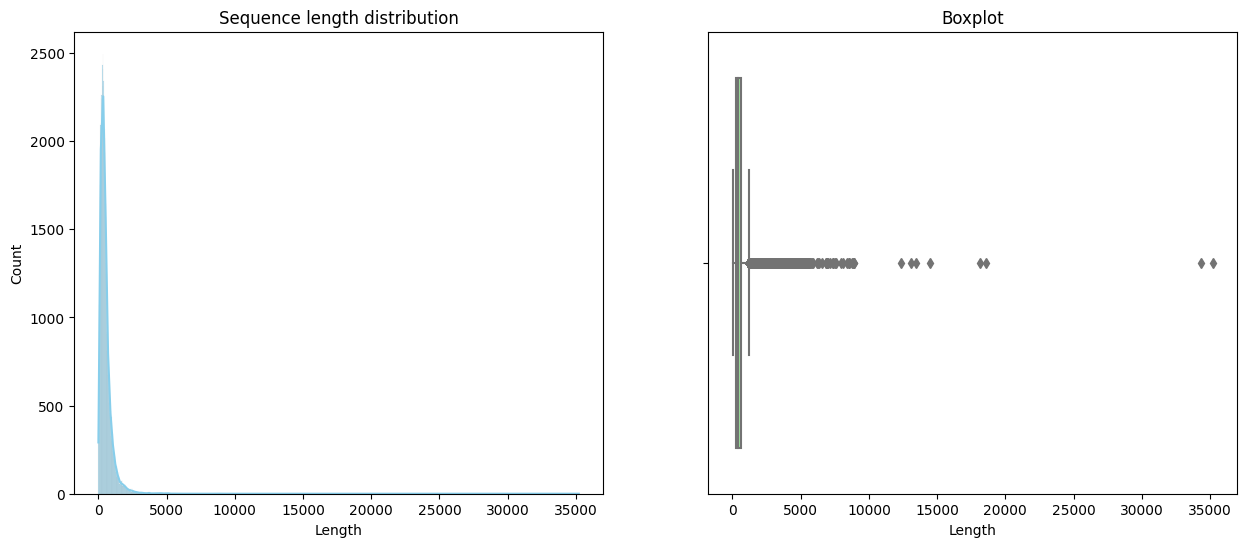

In [5]:
seq_lens = seq_df["Sequence"].apply(len)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Phân phối độ dài
sns.histplot(seq_lens, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Sequence length distribution')
axes[0].set_xlabel('Length')
axes[0].set_ylabel('Count')

# Boxplot
sns.boxplot(x=seq_lens, ax=axes[1], color='lightgreen')
axes[1].set_title('Boxplot')
axes[1].set_xlabel('Length')

Removing sequences longer than 2375.0 (Top 1%)
After filtering, training size: 81578


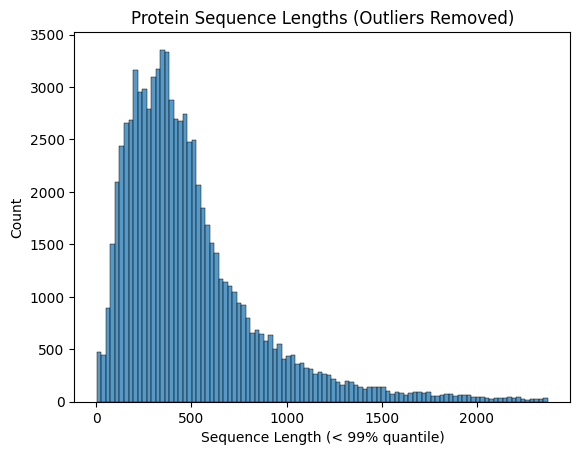

In [6]:
prob_keep = 99
cutoff = np.percentile(seq_lens, prob_keep)

print(f"Removing sequences longer than {cutoff} (Top {100-prob_keep}%)")

filtered_seq_df = seq_df[seq_lens < cutoff].copy()
print("After filtering, training size:", len(filtered_seq_df))

sns.histplot(filtered_seq_df["Sequence"].apply(len), bins=100)
plt.xlabel(f"Sequence Length (< {prob_keep}% quantile)")
plt.ylabel("Count")
plt.title("Protein Sequence Lengths (Outliers Removed)")
plt.show()

In [7]:
# Thống kê ký tự trong sequence
from collections import Counter

aa_counter = Counter()
for seq in seq_df['Sequence']:
    aa_counter.update(seq)

# Chuyển kết quả sang DataFrame để dễ quan sát
aa_stats = pd.DataFrame.from_dict(aa_counter, orient='index', columns=['Count'])
aa_stats.index.name = 'Amino_Acid'

# 2. Tính phần trăm (Frequency)
total_residues = aa_stats['Count'].sum()
aa_stats['Frequency (%)'] = (aa_stats['Count'] / total_residues) * 100

# Sắp xếp từ phổ biến nhất đến ít nhất
aa_stats = aa_stats.sort_values('Count', ascending=False)

# 3. Hiển thị bảng thống kê tổng quát
print("--- Thống kê tần suất Axit amin ---")
print(f"Tổng số ký tự (Residues): {total_residues:,}")
print(aa_stats)

--- Thống kê tần suất Axit amin ---
Tổng số ký tự (Residues): 43,327,058
              Count  Frequency (%)
Amino_Acid                        
L           4181227       9.650383
S           3597577       8.303303
A           3045567       7.029249
E           2939528       6.784509
G           2773867       6.402159
V           2695646       6.221623
K           2554736       5.896399
P           2393286       5.523768
T           2360559       5.448233
R           2320830       5.356537
D           2250638       5.194532
I           2180599       5.032880
Q           1906005       4.399110
N           1847443       4.263947
F           1684904       3.888803
Y           1245800       2.875339
H           1043404       2.408204
M            979122       2.259840
C            813693       1.878025
W            511941       1.181573
X               546       0.001260
U               138       0.000319
B                 2       0.000005


## Training term **train_term.tsv** file

List of annotated terms (**ground truth**) for the proteins in `train_sequences.fasta`

**1**. `EntryID`: UniProt ID (protein ID)

**2**. `term`: GO term (label in this data)

**3**. `aspect`: Ontology

In [8]:
term_df = pd.read_csv(term_path, sep='\t')
term_df.info()
display(term_df.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537027 entries, 0 to 537026
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   EntryID  537027 non-null  object
 1   term     537027 non-null  object
 2   aspect   537027 non-null  object
dtypes: object(3)
memory usage: 12.3+ MB


,EntryID,term,aspect
0,Q5W0B1,GO:0000785,C
1,Q5W0B1,GO:0004842,F
2,Q5W0B1,GO:0051865,P


In [9]:
term_df['term'].value_counts()

term
GO:0005515    33713
GO:0005634    13283
GO:0005829    13040
GO:0005886    10150
GO:0005737     9442
              ...  
GO:0010622        1
GO:0042357        1
GO:0009421        1
GO:0008764        1
GO:0061336        1
Name: count, Length: 26125, dtype: int64

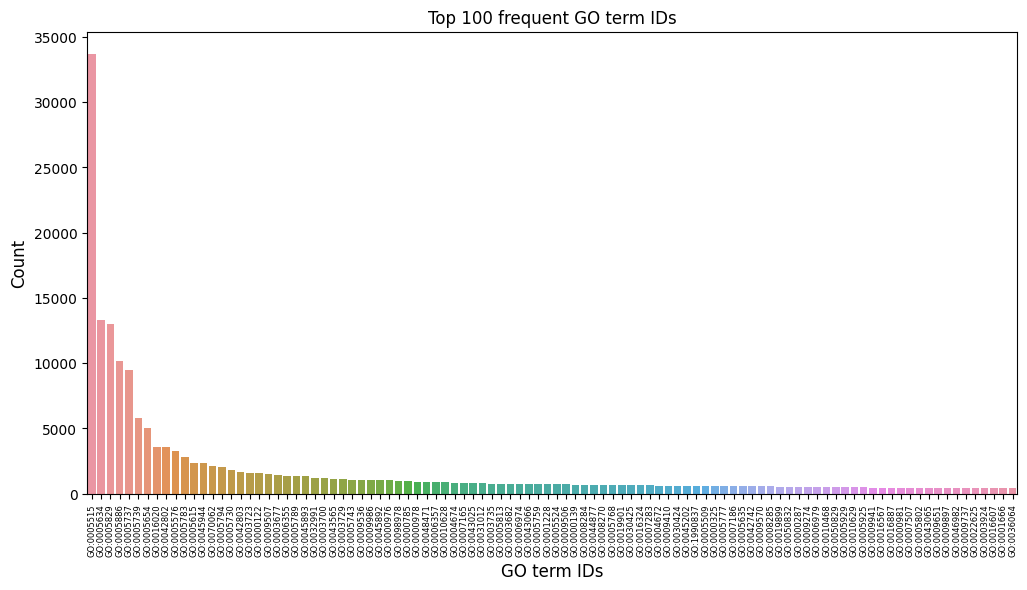

In [10]:
plot_df = term_df['term'].value_counts().iloc[:100]

figure, axis = plt.subplots(1, 1, figsize=(12, 6))

bp = sns.barplot(ax=axis, x=np.array(plot_df.index), y=plot_df.values)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 6)
axis.set_title('Top 100 frequent GO term IDs')
bp.set_xlabel("GO term IDs", fontsize = 12)
bp.set_ylabel("Count", fontsize = 12)
plt.show()

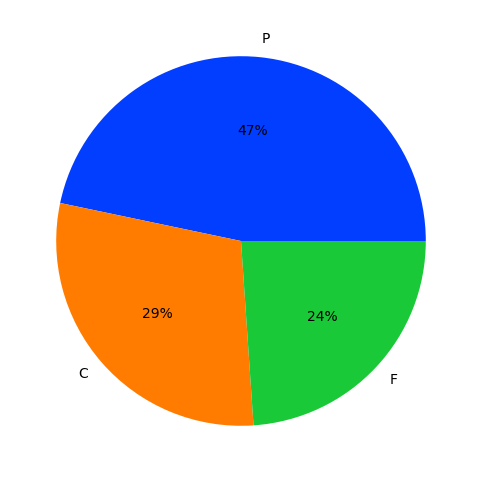

In [11]:
full_labels = term_df['term'].value_counts().index[:].tolist()

figure, axis = plt.subplots(1, 1, figsize=(12, 6))

train_terms_updated = term_df.loc[term_df['term'].isin(full_labels)]
pie_df = train_terms_updated['aspect'].value_counts()
palette_color = sns.color_palette('bright')
plt.pie(pie_df.values, labels=np.array(pie_df.index), colors=palette_color, autopct='%.0f%%')
plt.show()

In [12]:
aspects_per_term = term_df.groupby('term')['aspect'].nunique()
print("--- Thống kê số lượng aspect của mỗi term ---")
print(aspects_per_term.value_counts().sort_index())

mult_aspect_terms = aspects_per_term[aspects_per_term > 1]
if not mult_aspect_terms.empty:
    print(f"\nCó {len(mult_aspect_terms)} term thuộc nhiều aspect khác nhau.")
    print(mult_aspect_terms.head())
else:
    print("\n=> Mỗi term chỉ thuộc duy nhất 1 aspect.")

--- Thống kê số lượng aspect của mỗi term ---
aspect
1    26125
Name: count, dtype: int64

=> Mỗi term chỉ thuộc duy nhất 1 aspect.


In [13]:
!head -n 10 /kaggle/input/test-data/IA.tsv

GO:0000001	0.0
GO:0000002	2.8496657269155685
GO:0000011	0.13750352374993496
GO:0000012	6.038630248164372
GO:0000017	0.5145731728297583
GO:0000018	1.8796369862750815
GO:0000019	3.584962500721156
GO:0000022	0.0
GO:0000023	3.3115861506659034
GO:0000024	0.0


## Taxonomy training **train_taxonomy.tsv**

`ID` : Protein ID

`Taxonomy`: ID of the species to which they belong

In [14]:
tax_df = pd.read_csv(tax_path, sep='\t', header=None, names=['ID', 'taxonomy'])
tax_df.info()
display(tax_df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82404 entries, 0 to 82403
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        82404 non-null  object
 1   taxonomy  82404 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


,ID,taxonomy
0,A0A0C5B5G6,9606
1,A0JNW5,9606
2,A0JP26,9606
3,A0PK11,9606
4,A1A4S6,9606


In [15]:
tax_df['taxonomy'].value_counts()

taxonomy
9606      17162
10090     12508
3702      11863
559292     5520
10116      4909
          ...  
483148        1
145953        1
7048          1
6669          1
4568          1
Name: count, Length: 1381, dtype: int64

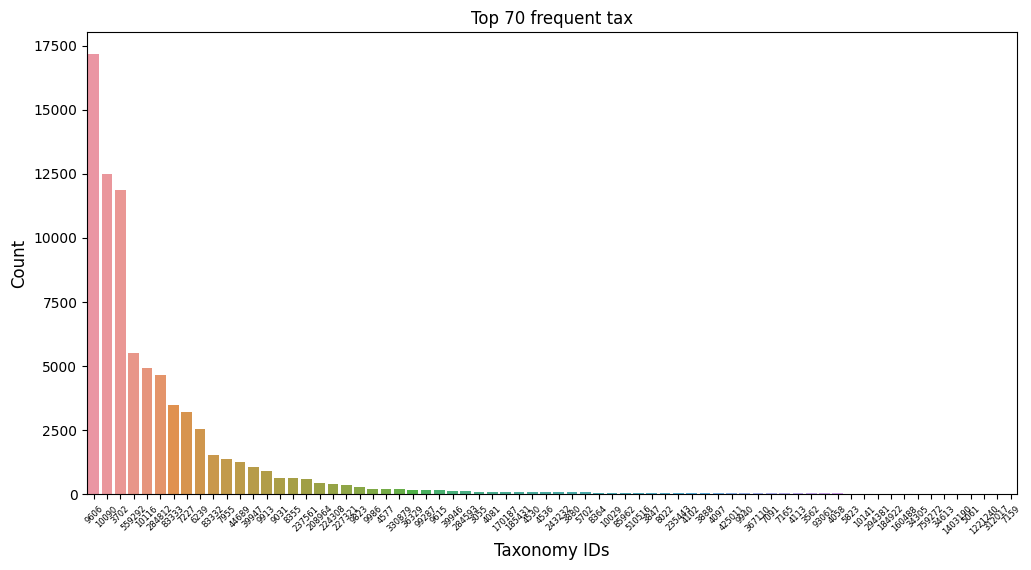

In [16]:
tax_plot = tax_df['taxonomy'].value_counts().iloc[:70]

figure, axis = plt.subplots(1, 1, figsize=(12, 6))

bp = sns.barplot(ax=axis, x=np.array(tax_plot.index), y=tax_plot.values, order=tax_plot.index)
bp.set_xticklabels(bp.get_xticklabels(), rotation=45, size = 6)
axis.set_title('Top 70 frequent tax')
bp.set_xlabel("Taxonomy IDs", fontsize = 12)
bp.set_ylabel("Count", fontsize = 12)
plt.show()

# Embedding analysis

## 1. ProtTrans

In [17]:
X = np.load("/kaggle/input/cafa-6-t5-embeddings/train_embeds.npy")
ids = np.load("/kaggle/input/cafa-6-t5-embeddings/train_ids.npy", allow_pickle=True)
ids = np.array([name.split("|")[1] for name in ids])
id2em = {idx: emb for idx, emb in zip(ids, X)}

print(X.shape)    
print(ids.shape)  

print(term_df.head())

(82404, 1024)
(82404,)
  EntryID        term aspect
0  Q5W0B1  GO:0000785      C
1  Q5W0B1  GO:0004842      F
2  Q5W0B1  GO:0051865      P
3  Q5W0B1  GO:0006275      P
4  Q5W0B1  GO:0006513      P


### GO term in embedding

In [18]:
# Đếm tần suất mỗi term
term_counts = term_df['term'].value_counts()
top_terms = term_counts.head(10).index.tolist()
print("Top 10 GO terms:", top_terms)
print(term_counts.head(10))

print("\n----Select 5 medium freq terms-------")
top_terms = top_terms[3:8]
top_terms

Top 10 GO terms: ['GO:0005515', 'GO:0005634', 'GO:0005829', 'GO:0005886', 'GO:0005737', 'GO:0005739', 'GO:0005654', 'GO:0016020', 'GO:0042802', 'GO:0005576']
term
GO:0005515    33713
GO:0005634    13283
GO:0005829    13040
GO:0005886    10150
GO:0005737     9442
GO:0005739     5807
GO:0005654     5065
GO:0016020     3563
GO:0042802     3547
GO:0005576     3241
Name: count, dtype: int64

----Select 5 medium freq terms-------


['GO:0005886', 'GO:0005737', 'GO:0005739', 'GO:0005654', 'GO:0016020']

In [19]:
# Assign each protein to one popular term for analysis
top_term_df = term_df[term_df['term'].isin(top_terms)].copy()
term_rank = {term: rank for rank, term in enumerate(term_counts.index)}
top_term_df = top_term_df[top_term_df['term'].isin(top_terms)].copy()

top_term_df['term_rank'] = top_term_df['term'].map(term_rank)
top_term_df = top_term_df.sort_values(['EntryID', 'term_rank'])

# Each ProteinID -> 1 Term
one_label_df = top_term_df.drop_duplicates(subset='EntryID', keep='first')
print("Số dòng thuộc top 5 term:", len(top_term_df))
print("Số protein có ít nhất 1 trong 5 term:", one_label_df['EntryID'].nunique())
one_label_df.head()

Số dòng thuộc top 5 term: 34027
Số protein có ít nhất 1 trong 5 term: 28145


,EntryID,term,aspect,term_rank
413241,A0A023PZB3,GO:0005739,C,5
392909,A0A059TC02,GO:0005737,C,4
496710,A0A061ACU2,GO:0005886,C,3
184346,A0A068FIK2,GO:0005737,C,4
504851,A0A075B6P5,GO:0005886,C,3


In [20]:
max_per_term = 1500

sampled_rows = []

for t in top_terms:
    sub = one_label_df[one_label_df['term'] == t]
    if len(sub) > max_per_term:
        sub = sub.sample(n=max_per_term, random_state=42)
    sampled_rows.append(sub)

sampled_df = pd.concat(sampled_rows, axis=0)
print("Tổng số protein được dùng để mapping SNE:", len(sampled_df))

Tổng số protein được dùng để mapping SNE: 7500


In [21]:
# Lấy list embeddings
emb_list = sampled_df["EntryID"].map(id2em)
emb_list = emb_list.dropna()

X_sample = np.stack(emb_list.values)
print(X_sample.shape)

labels = sampled_df.loc[emb_list.index, 'term'].values

(7500, 1024)


In [22]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA 
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_sample)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    n_iter=2000,
    random_state=42,
    init="pca"
)
X_2d = tsne.fit_transform(X_pca)

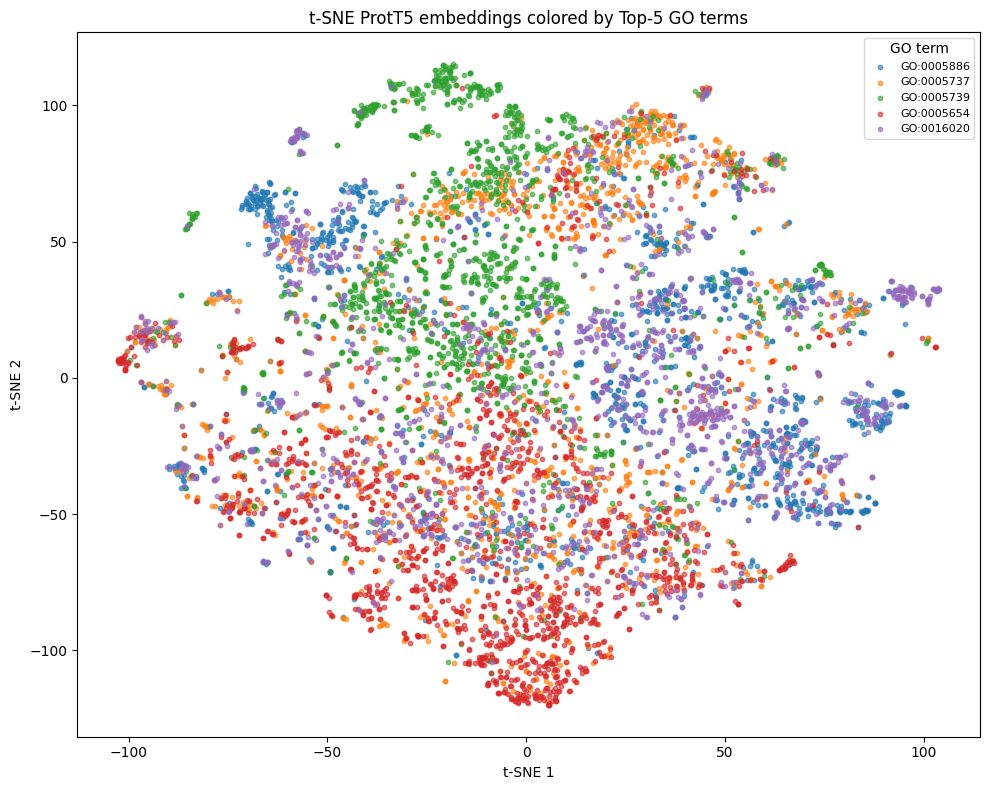

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Mỗi term 1 màu
unique_terms = list(sampled_df['term'].unique())
for t in unique_terms:
    mask = (labels == t)
    plt.scatter(
        X_2d[mask, 0],
        X_2d[mask, 1],
        s=10,
        alpha=0.6,
        label=t
    )

plt.legend(title="GO term", fontsize=8)
plt.title("t-SNE ProtT5 embeddings colored by Top-5 GO terms")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()

### Aspect in embedding

In [24]:
N_PER_BRANCH = 1000

aspect_sampled_df = (
    term_df
    .groupby("aspect", group_keys=False)
    .apply(lambda x: x.sample(
        n=min(len(x), N_PER_BRANCH),
        random_state=42
    ))
)

print(aspect_sampled_df['aspect'].value_counts())

aspect
C    1000
F    1000
P    1000
Name: count, dtype: int64


In [25]:
X_sample = np.stack(
    aspect_sampled_df['EntryID'].map(id2em).values
)

labels_branch = aspect_sampled_df['aspect'].values

print(X_sample.shape)

(3000, 1024)


In [26]:
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_sample)

tsne3 = TSNE(
    n_components=3,
    perplexity=30,
    n_iter=2000,
    random_state=42,
    init="pca"
)

X_3d = tsne3.fit_transform(X_pca)

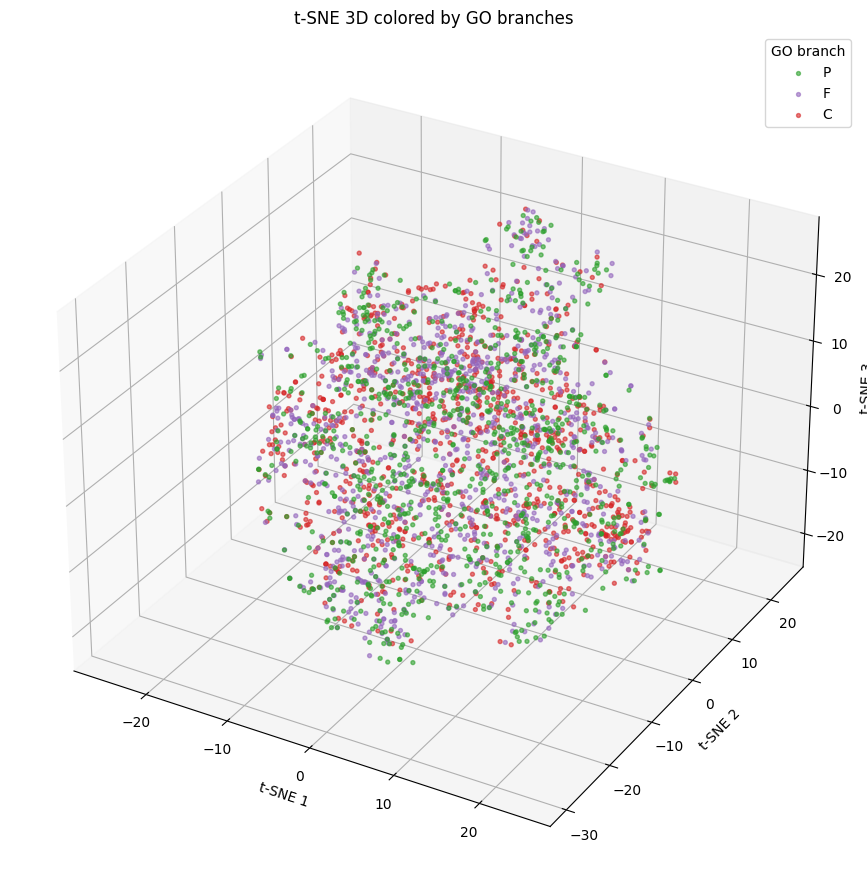

In [27]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import matplotlib.pyplot as plt

color_map = {'P': 'tab:green', 'F': 'tab:purple', 'C': 'tab:red'}

fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(111, projection='3d')

for b in ['P', 'F', 'C']:
    mask = (labels_branch == b)
    ax.scatter(
        X_3d[mask, 0], X_3d[mask, 1], X_3d[mask, 2],
        s=8, alpha=0.6,
        c=color_map[b],
        label=b
    )

ax.set_title("t-SNE 3D colored by GO branches")
ax.set_xlabel("t-SNE 1"); ax.set_ylabel("t-SNE 2"); ax.set_zlabel("t-SNE 3")
ax.legend(title="GO branch")
plt.tight_layout()
plt.show()

## 2. ESM2

In [28]:
!wc -l /kaggle/input/cafa6-protein-embeddings-esm2/protein_ids.csv

287002 /kaggle/input/cafa6-protein-embeddings-esm2/protein_ids.csv


In [29]:
X = np.load("/kaggle/input/cafa6-protein-embeddings-esm2/protein_embeddings.npy")
ids = pd.read_csv(
    "/kaggle/input/cafa6-protein-embeddings-esm2/protein_ids.csv",
    sep="\t",
    header=0        
)['protein_id'].astype(str).values


id2em = {idx: emb for idx, emb in zip(ids, X)}

print(X.shape)    
print(ids.shape) 

(287001, 1280)
(287001,)


In [30]:
max_per_term = 1500

sampled_rows = []

for t in top_terms:
    sub = one_label_df[one_label_df['term'] == t]
    if len(sub) > max_per_term:
        sub = sub.sample(n=max_per_term, random_state=42)
    sampled_rows.append(sub)

sampled_df = pd.concat(sampled_rows, axis=0)
print("Tổng số protein được dùng để mapping SNE:", len(sampled_df))

Tổng số protein được dùng để mapping SNE: 7500


In [31]:
# Lấy list embeddings
emb_list = sampled_df["EntryID"].map(id2em)
emb_list = emb_list.dropna()

X_sample = np.stack(emb_list.values)
print(X_sample.shape)

labels = sampled_df.loc[emb_list.index, 'term'].values

(7500, 1280)


In [32]:
# PCA 
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_sample)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    n_iter=2000,
    random_state=42,
    init="pca"
)
X_2d = tsne.fit_transform(X_pca)

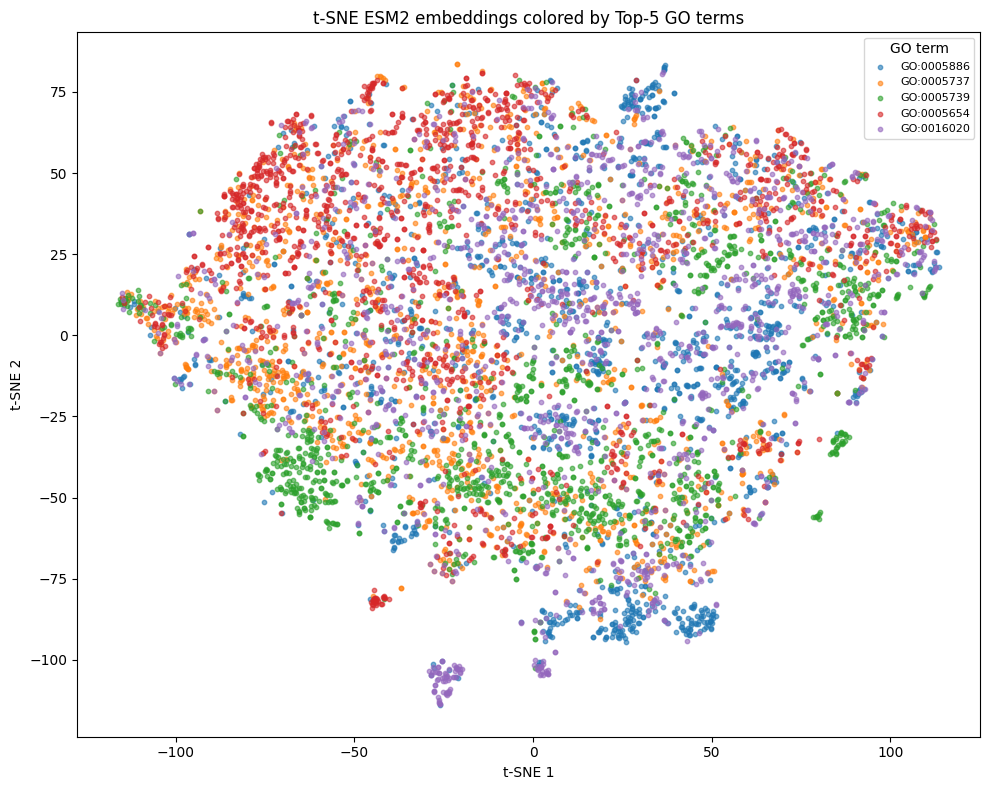

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Mỗi term 1 màu
unique_terms = list(sampled_df['term'].unique())
for t in unique_terms:
    mask = (labels == t)
    plt.scatter(
        X_2d[mask, 0],
        X_2d[mask, 1],
        s=10,
        alpha=0.6,
        label=t
    )

plt.legend(title="GO term", fontsize=8)
plt.title("t-SNE ESM2 embeddings colored by Top-5 GO terms")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()

In [34]:
N_PER_BRANCH = 1000

aspect_sampled_df = (
    term_df
    .groupby("aspect", group_keys=False)
    .apply(lambda x: x.sample(
        n=min(len(x), N_PER_BRANCH),
        random_state=42
    ))
)

print(aspect_sampled_df['aspect'].value_counts())

X_sample = np.stack(
    aspect_sampled_df['EntryID'].map(id2em).values
)

labels_branch = aspect_sampled_df['aspect'].values

print(X_sample.shape)

aspect
C    1000
F    1000
P    1000
Name: count, dtype: int64
(3000, 1280)


In [35]:
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_sample)

tsne3 = TSNE(
    n_components=3,
    perplexity=30,
    n_iter=2000,
    random_state=42,
    init="pca"
)

X_3d = tsne3.fit_transform(X_pca)

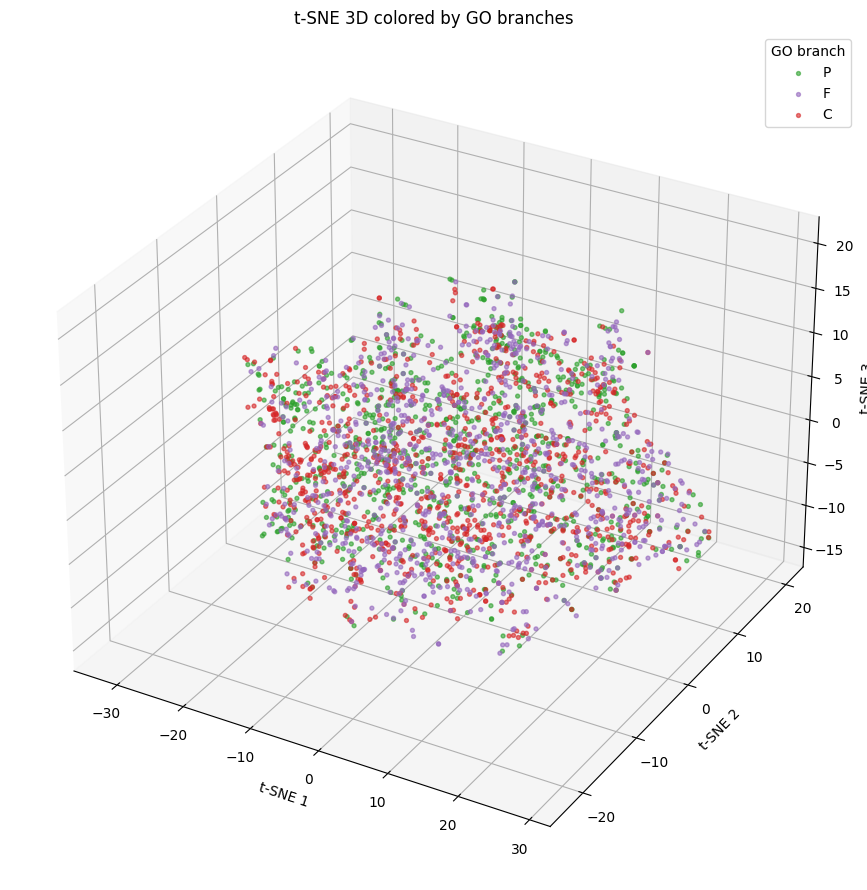

In [36]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import matplotlib.pyplot as plt

color_map = {'P': 'tab:green', 'F': 'tab:purple', 'C': 'tab:red'}

fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(111, projection='3d')

for b in ['P', 'F', 'C']:
    mask = (labels_branch == b)
    ax.scatter(
        X_3d[mask, 0], X_3d[mask, 1], X_3d[mask, 2],
        s=8, alpha=0.6,
        c=color_map[b],
        label=b
    )

ax.set_title("t-SNE 3D colored by GO branches")
ax.set_xlabel("t-SNE 1"); ax.set_ylabel("t-SNE 2"); ax.set_zlabel("t-SNE 3")
ax.legend(title="GO branch")
plt.tight_layout()
plt.show()